In [37]:
import Pkg
using CUDA
using Statistics
using Random
using Test
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using Plots; default(fmt=:png,ls=:auto)

import Knet
using Knet: conv4, pool, mat, sigm, KnetArray, nll, zeroone, progress, adam!, sgd!, param, param0, dropout, relu, minibatch, Data
import Knet: train!

using MLDatasets: MNIST

In [20]:
# Load data
xtrn, ytrn = MNIST.traindata(Float32); ytrn[ytrn.==0] .= 10;
xtst, ytst = MNIST.testdata(Float32);  ytst[ytst.==0] .= 10;

In [24]:
Knet.atype()

Array{Float32,N} where N

In [129]:
include("utils/nn.jl")

import .NN

In [130]:
function train!(model::NN.Chain, train_data::Data, test_data::Data;
                  period::Int=4, iters::Int=100, lr=0.15, optimizer=sgd!)  # or optimizer=adam!
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    
    for i in 0:period:iters
    
        push!(train_loss, model(train_data))
        push!(test_loss, model(test_data))
    
        push!(train_acc, model(train_data; accuracy=true))
        push!(test_acc, model(test_data; accuracy=true))
        
        optimizer(model, take(cycle(train_data), period); lr=lr)
        
    end
    
    return 0:period:iters, train_loss, train_acc, test_loss, test_acc
end

train! (generic function with 20 methods)

In [132]:
Random.seed!(13)
function leaky_relu(x; alpha=0.1)
    return max(x, alpha * x)
end

function leaky_relu2(x, alpha=0.1)
    pos = relu(x)
    neg = relu(-x)
    return pos - alpha * neg
end

model = NN.Chain(
    NN.Dense(784,30, leaky_relu2),
    NN.LeakyReLU(),
    NN.Dense(30,10,identity),
)

# Minibatches
dtrn = minibatch(xtrn, ytrn, 100; xsize = (28,28,1,:), xtype=Knet.atype(), shuffle=true);
dtst = minibatch(xtst, ytst, 100; xsize = (28,28,1,:), xtype=Knet.atype());

iters, trnloss, trnacc, tstloss, tstacc = train!(
    model, dtrn, dtst; 
    period=1, iters=50, lr=0.15, optimizer=sgd!);

println("Train loss: $(round(trnloss[end], digits=2)), Best train accuracy: $(ceil(maximum(trnacc), digits=2))")
println("Test loss: $(round(tstloss[end], digits=2)), Best test accuracy: $(ceil(maximum(tstacc), digits=2))")

plot(iters, trnloss, label="train", xlabel="Iterations", ylabel="Loss")
display(plot!(iters, tstloss, label="test"))

plot(iters, round.(1 .- trnacc, digits=2), label="train", xlabel="Iterations", ylabel="Misclassification error")
display(plot!(iters, round.(1 .- tstacc, digits=2), label="test"))

Iter: 0


LoadError: MethodError: no method matching reluback(::Float64, ::Float32)
Closest candidates are:
  reluback(!Matched::AutoGrad.Value{var"##782"}, ::var"##783") where {var"##782", var"##783"} at none:0
  reluback(::var"##782", !Matched::AutoGrad.Value{var"##783"}) where {var"##782", var"##783"} at none:0
  reluback(::T, !Matched::T) where T at /home/bcs/.julia/packages/Knet/LdQyF/src/ops20/activation.jl:27

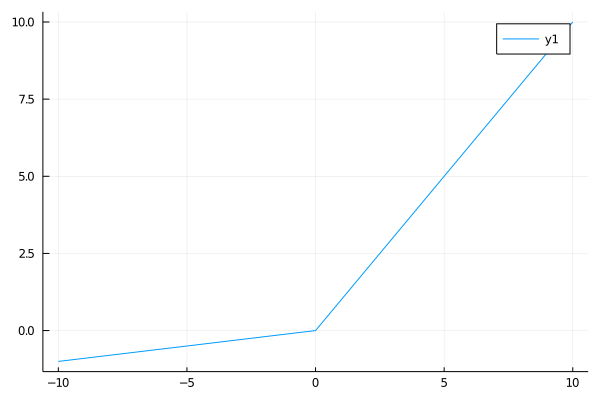

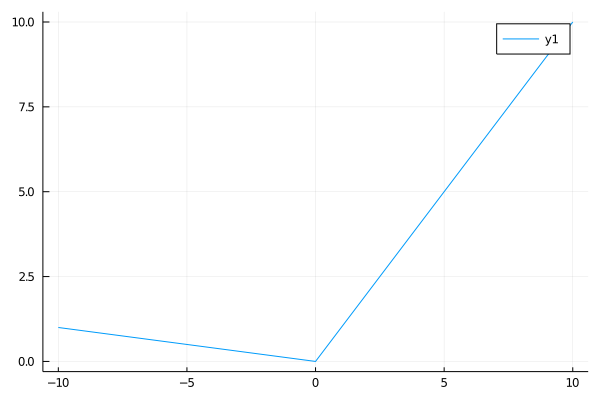

In [126]:
function leaky_relu(x; alpha=0.1)
    return max(x, alpha * x)
end

function leaky_relu2(x, alpha=0.1)
    pos = relu(x)
    neg = relu(-x)
    return pos + alpha * neg
end

xx = -10:0.01:10
yy = leaky_relu.(xx)
display(plot(xx, yy))

yy2 = leaky_relu2.(xx)
display(plot(xx, yy2))